<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [2]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as dafButler

# LSST package for image display
import lsst.afw.display as afwDisplay

from matplotlib import colormaps



### 1.2 Define Functions and Parameters

Import some functions from Pedro

In [3]:
import numpy as np 
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq
#Constants

A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

#values taken from sbpy for convenience

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2, 3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2, 1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1, 1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]


phi_1 = CubicSpline(alpha_12, phi_1_sp, bc_type=((1,phi_1_derivs[0]),(1,phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp, bc_type=((1,phi_2_derivs[0]),(1,phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp, bc_type=((1,phi_3_derivs[0]),(1,phi_3_derivs[1])))


def HG_model(phase, params):
    """
    Reference: Bowell et al. (1989)
    This is the oldest 2 parameter model. 
    """
    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)
    
    W = np.exp(-90.56 * tan_ah * tan_ah)    
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)
    
    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina
    
    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))
    
    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L
    return params[0] - 2.5*np.log10((1-params[1])* phi_1 + (params[1]) * phi_2) 



def HG1G2_model(phase, params):
    """
    Reference: Muinonen et al. (2010) https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract
    This is the 3 parameter model, which works best when you have a sufficiently long phaseangle coverage.
    """

    tan_ah = np.tan(phase/2)

    phi_1_ev = phi_1(phase)  
    phi_2_ev = phi_2(phase)  
    phi_3_ev = phi_3(phase)  

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6*phase[msk]/np.pi 
    phi_2_ev[msk] = 1- 9 * phase[msk]/(5*np.pi)

    phi_3_ev[phase > np.pi/6] = 0


    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)

def HG12_model(phase, params): 
    """
    Reference:
    Muinonen et al. (2010) https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract
    This is a simplified version of HG1G2. It's more useful when phaseangle coverage is shorter.
    """
    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162 
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164  
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

def chi2(params, mag, phase, mag_err, model):
    pred = model(phase, params)
    return (mag - pred)/mag_err

def fit(mag, phase, sigma, model=HG12_model, params=[0.1]):
    phase = np.deg2rad(phase)


    sol = leastsq(chi2, [mag[0]] + params,  (mag, phase, sigma, model), full_output = True)

    return sol




In [4]:
def fit_models(mag, magSigma, phaseAngle, tdist, rdist):

    # correct the mag to 1AU distance
    dmag = -5. * np.log10(tdist*rdist)
    mag = mag + dmag

    #double check if this is needed
    #phaseAngle = np.deg2rad(phaseAngle)

    # now we'll fit using each one of the HG, HG12 and HG1G2 models and store these in a dictionary of dictionaries
    solutions = {}

    #Let's do HG first
    sol_HG = fit(mag, phaseAngle, magSigma, model=HG_model)

    solutions['HG'] = {}

    solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
    solutions['HG']['H'] = sol_HG[0][0]
    solutions['HG']['G'] = sol_HG[0][1]
    solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0,0])
    solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1,1])
    solutions['HG']['cov'] = sol_HG[1]
            

    # now HG12
    sol_HG12 = fit(mag, phaseAngle, magSigma, model=HG12_model)

    solutions['HG12'] = {}

    solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
    solutions['HG12']['H'] = sol_HG12[0][0]
    solutions['HG12']['G12'] = sol_HG12[0][1]
    solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0,0])
    solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1,1])
    solutions['HG12']['cov'] = sol_HG12[1]

    # finally, HG1G2 - note this returns an extra parameter

    # now HG12, let's tell the code we need that extra parameter
    sol_HG1G2 = fit(mag, phaseAngle, magSigma, model=HG1G2_model, params=[0.1, 0.1])

    solutions['HG1G2'] = {}

    solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
    solutions['HG1G2']['H'] = sol_HG1G2[0][0]
    solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
    solutions['HG1G2']['G2'] = sol_HG1G2[0][1]
    solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0,0])
    solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1,1])
    solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2,2])

    solutions['HG1G2']['cov'] = sol_HG1G2[1]
    return solutions

## 2. Section Heading

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section Sub-heading

#### 2.1.1 Section Sub-sub-heading

In [5]:
service = get_tap_service("ssotap")

# select by NEO to get a larger range of orbital 
# need perihelion distance < 1 AU in MPCORB and on nobs is a lot? Or, select on long value of arc

# Need to check that the phase angle units in radians vs degrees. Function above by Pedro
# assumes they will be in degrees so may need to convert (check if goes to 90 or pi)

# need apparent magnitudes & uncertainties, phase angle topocentric (tdist) and heliocentric (rdist) distances & uncertainties (but they are 0; from SSSource)
#fitHG12 returns the absmag and phase coeff (G12) These will all be per band

# could also do the query using LEFT JOIN (i.e. specify a reference catalog to improve
# efficiency of the query)

In [32]:
# Object from Meg's notebook:
ssObjId = -9223369546614897710 #3728357697728353090

#ssObjId = 830638013891984606
# diaObjectId is the ID that links the individual measurements between DiaObject and SSSource,
# so you have to match on this id for unique measurement matching. 
# To then match this object to MPCORB and SSObject, you have
# to link on the SSObjectID (hwich is unique per solar system object)

query = "SELECT dia.mag, dia.diaSourceId, sss.diaSourceId, " + \
        "dia.magSigma, dia.filter, sss.phaseAngle, sss.topocentricDist, " + \
        "sss.heliocentricDist, dia.midPointTai, dia.ssObjectId, sss.ssObjectId " + \
        "FROM dp03_catalogs.DiaSource as dia " + \
        "JOIN dp03_catalogs.SSSource as sss " + \
        "ON dia.diaSourceId = sss.diaSourceId " + \
        "WHERE dia.ssObjectId = " + str(ssObjId) + ""



#query = "SELECT TOP 10000 * FROM dp03_catalogs.SSObject WHERE arc > 3000 ORDER by arc"
df = service.search(query).to_table() #.to_pandas()



whr = np.where(df['filter'] == 'r')[0]
whz = np.where(df['filter'] == 'z')[0]
whi = np.where(df['filter'] == 'i')[0]
whg = np.where(df['filter'] == 'g')[0]
print(df['magSigma'][whr])

  magSigma 
-----------
 0.09094866
 0.10273033
 0.20432276
 0.10001521
 0.13671595
 0.13456084
 0.09760618
 0.07672149
 0.08255493
 0.05461228
        ...
0.044325307
 0.08838216
 0.08728151
 0.09929389
 0.09439634
  0.0844865
  0.0683672
 0.08370233
 0.09087836
  0.1834496
 0.06519274
Length = 84 rows


   mag   
---------
23.534288
 23.65065
23.507633
23.633554
23.606396
23.568384
22.814022
23.034801
22.932205
22.621473
      ...
22.508577
22.684727
23.037596
 22.93708
22.876144
22.975634
22.813885
23.377497
23.149641
 23.55121
22.283636
Length = 84 rows phaseAngle
   deg    
----------
 19.716015
 19.713888
 19.887644
 15.969839
 15.137161
 15.137059
 7.4891887
  7.170834
  7.170668
 1.8916143
       ...
 19.616776
 19.616947
 19.027426
 17.708227
 20.314608
 18.583775
 22.569475
  21.93001
 22.560978
 17.091461
Length = 84 rows
84
filter
------
     g
     i
     r
     y
     z


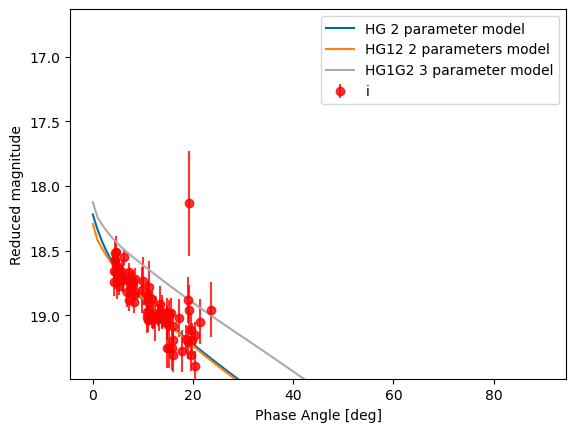

In [33]:
#plt.hist(df['mag'])
#plt.show()

#df['filter'][whr]
#df['filter'][whr]

#plt.plot(df['mag'][whr], df['magSigma'][whr])
#plt.show()

# Include these for distance correction to Reduced magnitude:
tdist = df['topocentricDist']
rdist = df['heliocentricDist']
dmag = -5. * np.log10(tdist*rdist)


#plt.errorbar(df['phaseAngle'][whr], df['mag'][whr]+dmag[whr], yerr=df['magSigma'][whr],fmt='o', alpha=.8,label='r band')
#plt.errorbar(df['phaseAngle'][whz], df['mag'][whz]+dmag[whz], yerr=df['magSigma'][whz],fmt='o', alpha=.8,label='z')
plt.errorbar(df['phaseAngle'][whi], df['mag'][whi]+dmag[whi], yerr=df['magSigma'][whi],fmt='ro', alpha=.8,label='i')
#plt.errorbar(df['phaseAngle'][whg], df['mag'][whg]+dmag[whg], yerr=df['magSigma'][whg],fmt='ok', alpha=.8,label='g')

#plt.ylim((np.max(df['mag'][whr]+dmag[whr])+.1,np.min(df['mag'][whr]+dmag[whr])-1.5))
plt.ylim((np.max(df['mag'][whi]+dmag[whi])+.1,np.min(df['mag'][whi]+dmag[whi])-1.5))
#plt.xlim(0,30)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude')

print(df['mag'][whr], df['phaseAngle'][whr])
print(len(whr))
print(np.unique(df['filter']))


#x = fit_models(df['mag'][whr], df['magSigma'][whr], df['phaseAngle'][whr], df['topocentricDist'][whr], df['heliocentricDist'][whr])
x = fit_models(df['mag'][whi], df['magSigma'][whi], df['phaseAngle'][whi], df['topocentricDist'][whi], df['heliocentricDist'][whi])


phases = np.linspace(0,90,100)
HG12_mag = HG12_model(np.deg2rad(phases), [x['HG12']['H'], x['HG12']['G12']])
HG_mag = HG_model(np.deg2rad(phases), [x['HG']['H'], x['HG']['G']])
HG1G2_mag = HG1G2_model(np.deg2rad(phases), [x['HG1G2']['H'], x['HG1G2']['G1'], x['HG1G2']['G2']])

plt.plot(phases, HG_mag, label ='HG 2 parameter model')
plt.plot(phases, HG12_mag, label='HG12 2 parameters model')
plt.plot(phases, HG1G2_mag, label='HG1G2 3 parameter model')

plt.legend()

plt.show()

#plt.show()
#len(wh)



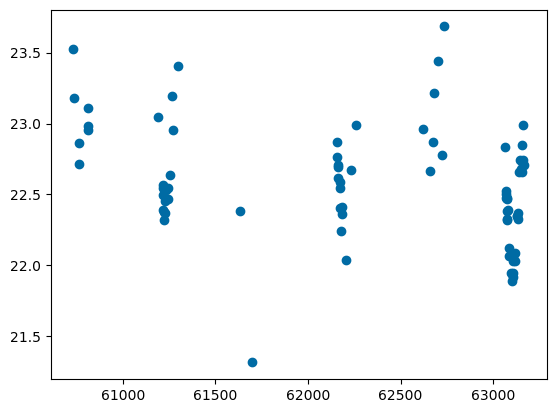

In [34]:
plt.plot(df['midPointTai'][whi],df['mag'][whi],'o')
plt.show()


In [ ]:
phases = np.linspace(0,90,100)
HG12_mag = HG12_model(np.deg2rad(phases), [x['HG12']['H'], x['HG12']['G12']])
plt.plot(phases, HG12_mag)

In [ ]:
query2 = "SELECT ssObjectId " + \
        "FROM dp03_catalogs.SSSource  " + \
        "WHERE ssObjectId = 830638013891984606"

df2 = service.search(query2).to_table().to_pandas()
df2

Junk Code Below

In [ ]:
#query1 = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc " + \
#        "FROM dp03_catalogs.MPCORB as mpc " + \
#        "INNER JOIN dp03_catalogs.SSObject as sso " + \
#        "ON mpc.ssObjectId = sso.ssObjectId " + \
#        "INNER JOIN dp03_catalogs.DiaSource as dia " + \
#        "ON mpc.ssObjectId = dia.ssObjectId " + \
#        "INNER JOIN dp03_catalogs.SSSource as sss " + \
#        "ON mpc.ssObjectId = sss.ssObjectId " + \
#        "WHERE mpc.ssObjectId > 1  AND sso.arc > 3000 "  + \
#        "AND mpc.q < 1 ORDER by sso.arc"

#query = "SELECT TOP 10000 * FROM dp03_catalogs.SSObject WHERE arc > 3000 ORDER by arc"
#df = service.search(query).to_table().to_pandas()
#df

In [ ]:
#query = "SELECT TOP 10000 * FROM dp03_catalogs.MPCORB WHERE q < 1 ORDER by arc"

# this takes too long:
#query = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc " + \
#        "FROM dp03_catalogs.MPCORB as mpc " + \
#        "JOIN dp03_catalogs.SSObject as sso " + \
#        "ON mpc.ssObjectId = sso.ssObjectId " + \
#        "JOIN dp03_catalogs.DiaSource as dia " + \
#        "ON mpc.ssObjectId = dia.ssObjectId " + \
#        "JOIN dp03_catalogs.SSSource as sss " + \
#        "ON mpc.ssObjectId = sss.ssObjectId " + \
#        "WHERE mpc.ssObjectId > 1  AND sso.arc > 3000 "  + \
#        "AND mpc.q < 1 ORDER by sso.arc"


In [ ]:

#query = "SELECT mpc.ssObjectId, mpc.q, sso.ssObjectId, sso.arc, dia.mag," + \
#        "dia.magSigma, dia.filter, sss.phaseAngle, sss.topocentricDist, " + \
#        "sss.heliocentricDist, dia.midPointTai " + \
#        "FROM dp03_catalogs.MPCORB as mpc " + \
#        "JOIN dp03_catalogs.SSObject as sso " + \
#        "ON mpc.ssObjectId = sso.ssObjectId " + \
#        "JOIN dp03_catalogs.DiaSource as dia " + \
#        "ON mpc.ssObjectId = dia.ssObjectId " + \
#        "JOIN dp03_catalogs.SSSource as sss " + \
#        "ON mpc.ssObjectId = sss.ssObjectId " + \
#        "WHERE sss.ssObjectId = 3728357697728353090"
